In [1]:
import keras
keras.__version__

Using TensorFlow backend.


'2.3.0'

# 주택 가격 예측: 회귀 문제

이 노트북은 [케라스 창시자에게 배우는 딥러닝](https://tensorflow.blog/%EC%BC%80%EB%9D%BC%EC%8A%A4-%EB%94%A5%EB%9F%AC%EB%8B%9D/) 책의 3장 6절의 코드 예제입니다. 책에는 더 많은 내용과 그림이 있습니다. 이 노트북에는 소스 코드에 관련된 설명만 포함합니다.

----

앞의 두 예제는 분류 문제입니다. 입력 데이터 포인트의 개별적인 레이블 하나를 예측하는 것이 목적입니다. 또 다른 종류의 머신 러닝 문제는 개별적인 레이블 대신에 연속적인 값을 예측하는 회귀(regression)입니다. 예를 들어 기상 데이터가 주어졌을 때 내일 기온을 예측하거나 소프트웨어 명세가 주어졌을 때 소프트웨어 프로젝트가 완료될 시간을 예측하는 것입니다.

회귀와 로지스틱 회귀 알고리즘을 혼돈하지 마세요. 로지스틱 회귀는 회귀 알고리즘이 아니라 분류 알고리즘입니다.

## 보스턴 주택 가격 데이터셋

1970년 중반 보스턴 외곽 지역의 범죄율, 지방세율 등의 데이터가 주어졌을 때 주택 가격의 중간 값을 예측해 보겠습니다.

여기서 사용할 데이터셋은 이전 두 개의 예제와 다릅니다. 데이터 포인트가 506개로 비교적 개수가 적고 404개는 훈련 샘플로 102개는 테스트 샘플로 나누어져 있습니다. 입력 데이터에 있는 각 특성(예를 들어 범죄율)은 스케일이 서로 다릅니다. 어떤 값은 0과 1 사이의 비율을 나타내고 어떤 것은 1과 12 사이의 값을 가지거나 1과 100 사이의 값을 가집니다.

데이터를 살펴보겠습니다:

In [2]:
from keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) =  boston_housing.load_data()

In [3]:
train_data.shape

(404, 13)

In [4]:
test_data.shape

(102, 13)

여기서 볼 수 있듯이 404개의 훈련 샘플과 102개의 테스트 샘플이 있고 모두 13개의 수치 특성을 가지고 있습니다. 13개의 특성은 다음과 같습니다:

1. Per capita crime rate.
2. Proportion of residential land zoned for lots over 25,000 square feet.
3. Proportion of non-retail business acres per town.
4. Charles River dummy variable (= 1 if tract bounds river; 0 otherwise).
5. Nitric oxides concentration (parts per 10 million).
6. Average number of rooms per dwelling.
7. Proportion of owner-occupied units built prior to 1940.
8. Weighted distances to five Boston employment centres.
9. Index of accessibility to radial highways.
10. Full-value property-tax rate per $10,000.
11. Pupil-teacher ratio by town.
12. 1000 * (Bk - 0.63) ** 2 where Bk is the proportion of Black people by town.
13. % lower status of the population.

타깃은 주택의 중간 가격으로 천달러 단위입니다:

In [5]:
train_targets

array([15.2, 42.3, 50. , 21.1, 17.7, 18.5, 11.3, 15.6, 15.6, 14.4, 12.1,
       17.9, 23.1, 19.9, 15.7,  8.8, 50. , 22.5, 24.1, 27.5, 10.9, 30.8,
       32.9, 24. , 18.5, 13.3, 22.9, 34.7, 16.6, 17.5, 22.3, 16.1, 14.9,
       23.1, 34.9, 25. , 13.9, 13.1, 20.4, 20. , 15.2, 24.7, 22.2, 16.7,
       12.7, 15.6, 18.4, 21. , 30.1, 15.1, 18.7,  9.6, 31.5, 24.8, 19.1,
       22. , 14.5, 11. , 32. , 29.4, 20.3, 24.4, 14.6, 19.5, 14.1, 14.3,
       15.6, 10.5,  6.3, 19.3, 19.3, 13.4, 36.4, 17.8, 13.5, 16.5,  8.3,
       14.3, 16. , 13.4, 28.6, 43.5, 20.2, 22. , 23. , 20.7, 12.5, 48.5,
       14.6, 13.4, 23.7, 50. , 21.7, 39.8, 38.7, 22.2, 34.9, 22.5, 31.1,
       28.7, 46. , 41.7, 21. , 26.6, 15. , 24.4, 13.3, 21.2, 11.7, 21.7,
       19.4, 50. , 22.8, 19.7, 24.7, 36.2, 14.2, 18.9, 18.3, 20.6, 24.6,
       18.2,  8.7, 44. , 10.4, 13.2, 21.2, 37. , 30.7, 22.9, 20. , 19.3,
       31.7, 32. , 23.1, 18.8, 10.9, 50. , 19.6,  5. , 14.4, 19.8, 13.8,
       19.6, 23.9, 24.5, 25. , 19.9, 17.2, 24.6, 13

이 가격은 일반적으로 10,000달러에서 50,000달러 사이입니다. 저렴하게 느껴질텐데 1970년대 중반이라는 걸 기억하세요. 아직 인플레이션에 영향을 받지 않은 가격입니다.

## 데이터 준비

상이한 스케일을 가진 값을 신경망에 주입하면 문제가 됩니다. 네트워크가 이런 다양한 데이터에 자동으로 맞추려고 할 수 있지만 이는 확실히 학습을 더 어렵게 만듭니다. 이런 데이터를 다룰 때 대표적인 방법은 특성별로 정규화를 하는 것입니다. 입력 데이터에 있는 각 특성(입력 데이터 행렬의 열)에 대해서 특성의 평균을 빼고 표준 편차로 나눕니다. 특성의 중앙이 0 근처에 맞춰지고 표준 편차가 1이 됩니다. 넘파이를 사용하면 간단하게 할 수 있습니다:

In [6]:
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std

테스트 데이터를 정규화할 때 사용한 값이 훈련 데이터에서 계산한 값임을 주목하세요. 머신 러닝 작업 과정에서 절대로 테스트 데이터에서 계산한 어떤 값도 사용해서는 안 됩니다. 데이터 정규화처럼 간단한 작업조차도 그렇습니다.

## 모델 구성

샘플의 개수가 적기 때문에 64개의 유닛을 가진 두 개의 은닉층으로 작은 네트워크를 구성하여 사용하겠습니다. 일반적으로 훈련 데이터의 개수가 적을수록 과대적합이 더 쉽게 일어나므로 작은 모델을 사용하는 것이 과대적합을 피하는 한 방법입니다.

In [7]:
from keras import models
from keras import layers

def build_model():
    # 동일한 모델을 여러 번 생성할 것이므로 함수를 만들어 사용합니다
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',
                           input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

이 네트워크의 마지막 층은 하나의 유닛을 가지고 있고 활성화 함수가 없습니다(선형 층이라고 합니다). 이것이 전형적인 스칼라 회귀(하나의 연속적인 값을 예측하는 회귀)를 위한 구성입니다. 활성화 함수를 적용하면 출력 값의 범위를 제한하게 됩니다. 예를 들어 마지막 층에 `sigmoid` 활성화 함수를 적용하면 네트워크가 0과 1 사이의 값을 예측하도록 학습될 것입니다. 여기서는 마지막 층이 순수한 선형이므로 네트워크가 어떤 범위의 값이라도 예측하도록 자유롭게 학습됩니다.

이 모델은 `mse` 손실 함수를 사용하여 컴파일합니다. 이 함수는 평균 제곱 오차(mean squared error)의 약자로 예측과 타깃 사이 거리의 제곱입니다. 회귀 문제에서 널리 사용되는 손실 함수입니다.

훈련하는 동안 모니터링을 위해 새로운 지표인 평균 절대 오차를 측정합니다. 이는 예측과 타깃 사이 거리의 절댓값입니다. 예를 들어 이 예제에서 MAE가 0.5이면 예측이 평균적으로 $500 정도 차이가 난다는 뜻입니다.

## K-겹 검증을 사용한 훈련 검증

(훈련에 사용할 에포크의 수 같은) 매개변수들을 조정하면서 모델을 평가하기 위해 이전 예제에서 했던 것처럼 데이터를 훈련 세트와 검증 세트로 나눕니다. 데이터 포인트가 많지 않기 때문에 검증 세트도 매우 작아집니다(약 100개의 샘플). 결국 검증 세트와 훈련 세트로 어떤 데이터 포인트가 선택됐는지에 따라 검증 점수가 크게 달라집니다. 검증 세트의 분할에 대한 검증 점수의 분산이 높습니다. 이렇게 되면 신뢰있는 모델 평가를 신뢰있게 할 수 없습니다.

이런 상황에서 가장 좋은 방법은 K-겹 교차 검증을 사용하는 것입니다. 데이터를 K개의 분할(즉, 폴드)로 나누고(일반적으로 K = 4 또는 5), K개의 모델을 각각 만들어 K - 1개의 분할에서 훈련하고 나머지 분할에서 평가하는 방법입니다. 모델의 검증 점수는 K 개의 검증 점수의 평균이 됩니다.

코드로 보면 이해하기 쉽습니다:

In [23]:
import tensorflow as tf
from keras.backend import tensorflow_backend as K
## tf backend config
gpu_fraction = 0.45
config = tf.compat.v1.ConfigProto()
#config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction=gpu_fraction
K.set_session(tf.compat.v1.Session(config=config))

## 메모리 해제
K.clear_session()

In [24]:
import numpy as np

k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []
for i in range(k):
    print('처리중인 폴드 #', i)
    # 검증 데이터 준비: k번째 분할
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    # 훈련 데이터 준비: 다른 분할 전체
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    # 케라스 모델 구성(컴파일 포함)
    model = build_model()
    # 모델 훈련(verbose=0 이므로 훈련 과정이 출력되지 않습니다)
    model.fit(partial_train_data, partial_train_targets,
              epochs=num_epochs, batch_size=1, verbose=0)
    # 검증 세트로 모델 평가
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

처리중인 폴드 # 0
처리중인 폴드 # 1
처리중인 폴드 # 2
처리중인 폴드 # 3


In [25]:
all_scores

[2.065694570541382, 2.6166412830352783, 2.6805715560913086, 2.667835235595703]

In [26]:
np.mean(all_scores)

2.507685661315918

검증 세트가 다르므로 확실히 검증 점수가 2.0에서 2.8까지 변화가 큽니다. 평균값(2.4)이 각각의 점수보다 훨씬 신뢰할 만한 점수입니다. 이것이 K-겹 교차 검증의 핵심입니다. 이 예에서는 평균적으로 3,000달러 정도 차이가 납니다. 주택 가격의 범위가 10,000달러에서 50,000달러 사이인 것을 감안하면 비교적 큰 값입니다.

신경망을 조금 더 오래 500 에포크 동안 훈련해 보죠. 각 에포크마다 모델이 얼마나 개선되는지 기록하기 위해 훈련 루프를 조금 수정해서 에포크의 검증 점수를 로그에 저장하겠습니다:

In [27]:
from keras import backend as K

# 메모리 해제
K.clear_session()

In [28]:
print(history.history.keys())

dict_keys(['val_loss', 'val_mae', 'loss', 'mae'])


In [29]:
num_epochs = 500
all_mae_histories = []
for i in range(k):
    print('처리중인 폴드 #', i)
    # 검증 데이터 준비: k번째 분할
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    # 훈련 데이터 준비: 다른 분할 전체
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    # 케라스 모델 구성(컴파일 포함)
    model = build_model()
    # 모델 훈련(verbose=0 이므로 훈련 과정이 출력되지 않습니다)
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=0)
#    mae_history = history.history['val_mean_absolute_error']
    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)

처리중인 폴드 # 0
처리중인 폴드 # 1
처리중인 폴드 # 2
처리중인 폴드 # 3


그다음 모든 폴드에 대해 에포크의 MAE 점수의 평균을 계산합니다:

In [30]:
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

그래프로 그려 보겠습니다:

In [31]:
import matplotlib.pyplot as plt

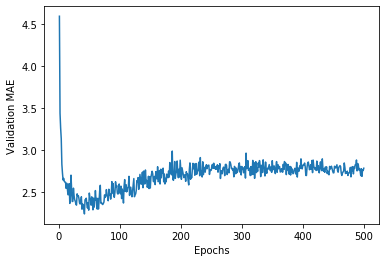

In [32]:
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

이 그래프는 범위가 크고 변동이 심하기 때문에 보기가 좀 어렵습니다. 다음처럼 해 보죠:

* 곡선의 다른 부분과 스케일이 많이 다른 첫 10개 데이터 포인트를 제외시킵니다.
* 부드러운 곡선을 얻기 위해 각 포인트를 이전 포인트의 지수 이동 평균으로 대체합니다.

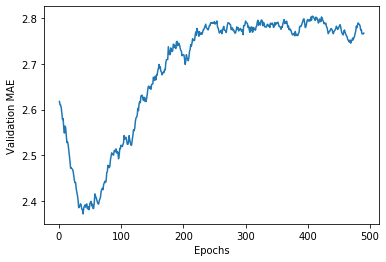

In [34]:
def smooth_curve(points, factor=0.9):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

이 그래프를 보면 검증 MAE가 80번째 에포크 이후에 줄어드는 것이 멈추었습니다. 이 지점 이후로는 과대적합이 시작됩니다.

모델의 다른 매개변수에 대한 튜닝이 끝나면(에포크 수뿐만 아니라 은닉층의 크기도 조절할 수 있습니다) 모든 훈련 데이터를 사용하고 최상의 매개변수로 최종 실전에 투입될 모델을 훈련시킵니다. 그다음 테스트 데이터로 성능을 확인합니다:

In [35]:
# 새롭게 컴파인된 모델을 얻습니다
model = build_model()
# 전체 데이터로 훈련시킵니다
model.fit(train_data, train_targets,
          epochs=80, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

102/102 [==============================] - 0s 304us/step


In [36]:
test_mae_score

2.657597064971924

아직 2,675달러 정도 차이가 나네요.

## 정리

다음은 이 예제에서 배운 것들입니다.

* 회귀는 분류에서 사용했던 것과는 다른 손실 함수를 사용합니다. 평균 제곱 오차(MSE)는 회귀에서 자주 사용되는 손실 함수입니다.
* 비슷하게 회귀에서 사용되는 평가 지표는 분류와 다릅니다. 당연히 정확도 개념은 회귀에 적용되지 않습니다. 일반적인 회귀 지표는 평균 절대 오차(MAE)입니다.
* 입력 데이터의 특성이 서로 다른 범위를 가지면 전처리 단계에서 각 특성을 개별적으로 스케일 조정해야 합니다.
* 가용한 데이터가 적다면 K-겹 검증을 사용하는 것이 신뢰할 수 있는 모델 신뢰있게 평가 방법입니다.
* 가용한 훈련 데이터가 적다면 과대적합을 피하기 위해 은닉층의 수를 줄인 모델이 좋습니다(일반적으로 하나 또는 두 개).

세 개의 예제 시리즈를 마칩니다. 이제 벡터 데이터 입력을 받는 일반적인 문제를 다룰 수 있습니다:

* 이진 분류
* 단일 레이블 다중 분류
* 스칼라 회귀

다음 장에서 이 예제들에서 보았던 데이터 전처리, 모델 평가, 과대접과 같은 개념에 대해 조금 더 이론적인 설명을 보완하겠습니다.